# Modeling time series Part I : Pandas tutorial



The dataset for this part is based on a Household Electric Power Consumption dataset (https://www.kaggle.com/uciml/electric-power-consumption-data-set/) 

It contains 2075259 measurements gathered between December 2006 and November 2010 (47 months). Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. 

## Data Description

The data that we will use are:

1. `date`: Date in format dd/mm/yyyy

2. `time`: time in format hh:mm:ss

3. `globalactivepower`: household global minute-averaged active power (in kilowatt)


This section will cover the standard use case of data manipulation using pandas.

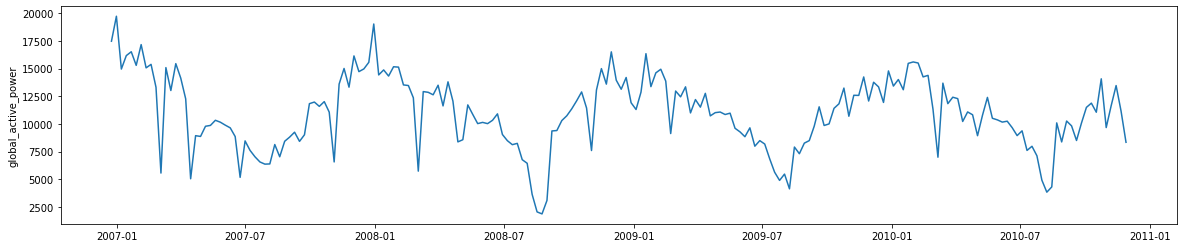

Download the dataset and import standard libraries.

In [ ]:
!wget https://raw.githubusercontent.com/sunnypwang/mwa_workshop/master/lab2/122_260_bundle_archive.zip

--2021-08-02 08:48:38--  https://raw.githubusercontent.com/sunnypwang/mwa_workshop/master/lab2/122_260_bundle_archive.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20357475 (19M) [application/zip]
Saving to: ‘122_260_bundle_archive.zip’

122_260_bundle_arch 100%[===================>]  19.41M  --.-KB/s    in 0.1s    

2021-08-02 08:48:39 (152 MB/s) - ‘122_260_bundle_archive.zip’ saved [20357475/20357475]



In [ ]:
from datetime import datetime
import numpy as np            
import pandas as pd            
import matplotlib.pylab as plt 
%matplotlib inline             
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load the data

The data could be read by using `pd.read_csv`.

In [ ]:
df = pd.read_csv('122_260_bundle_archive.zip', sep=';',  low_memory=False, na_values=['nan','?'])
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


As you can see, the column `Date` and `time` are two different columns. We could simplify this by merging and converting them into a `datetime` data type by setting `parse_dates` and `infer_datetime_format` arguments.

In [ ]:
df = pd.read_csv('122_260_bundle_archive.zip', sep=';', 
                 parse_dates={'datetime' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'])
df.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


Now we convert the `datetime` column and use them as an index (`Index` data type). The pandas `Index` supports a lot of useful functionalities which we will mention later.


In [ ]:
df = df.set_index('datetime')
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


The index could be accessed by using calling the attribute index.

In [ ]:
df.index

DatetimeIndex(['2006-12-16 17:24:00', '2006-12-16 17:25:00',
               '2006-12-16 17:26:00', '2006-12-16 17:27:00',
               '2006-12-16 17:28:00', '2006-12-16 17:29:00',
               '2006-12-16 17:30:00', '2006-12-16 17:31:00',
               '2006-12-16 17:32:00', '2006-12-16 17:33:00',
               ...
               '2010-11-26 20:53:00', '2010-11-26 20:54:00',
               '2010-11-26 20:55:00', '2010-11-26 20:56:00',
               '2010-11-26 20:57:00', '2010-11-26 20:58:00',
               '2010-11-26 20:59:00', '2010-11-26 21:00:00',
               '2010-11-26 21:01:00', '2010-11-26 21:02:00'],
              dtype='datetime64[ns]', name='datetime', length=2075259, freq=None)

The code below shows how to access the columns in the dataframe.

In [ ]:
df[ ['Global_active_power', 'Global_reactive_power']].head()

,Global_active_power,Global_reactive_power
datetime,,
2006-12-16 17:24:00,4.216,0.418
2006-12-16 17:25:00,5.360,0.436
2006-12-16 17:26:00,5.374,0.498
2006-12-16 17:27:00,5.388,0.502
2006-12-16 17:28:00,3.666,0.528


In [ ]:
df.Global_active_power

datetime
2006-12-16 17:24:00    4.216
2006-12-16 17:25:00    5.360
2006-12-16 17:26:00    5.374
2006-12-16 17:27:00    5.388
2006-12-16 17:28:00    3.666
                       ...  
2010-11-26 20:58:00    0.946
2010-11-26 20:59:00    0.944
2010-11-26 21:00:00    0.938
2010-11-26 21:01:00    0.934
2010-11-26 21:02:00    0.932
Name: Global_active_power, Length: 2075259, dtype: float64

## Data cleaning

We check if the data contains missing values by calling `isnull` method.

In [ ]:
for i in range(len(df.columns)):
  print("Null in any column {} = {}".format(df.columns[i], any(df.iloc[:, i].isnull())))


Null in any column Global_active_power = True
Null in any column Global_reactive_power = True
Null in any column Voltage = True
Null in any column Global_intensity = True
Null in any column Sub_metering_1 = True
Null in any column Sub_metering_2 = True
Null in any column Sub_metering_3 = True


We found that every column has at least one missing value. For simplicity, we fill them with the mean of the column. Note that this really depends on your dataset, and should be handled with care.

There are a lot of options provided in [fillna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html) that you can also consider such as *limit*, *ffill*, and *bfill*. You can also perform interpolation of missing values via [interpolate](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.interpolate.html).

In [ ]:
# filling nan with mean in any columns
for j in range(0,len(df.columns)):        
    df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

Now the missing values are now filled.

In [ ]:
for i in range(len(df.columns)):
  print("Null in any column {} = {}".format(df.columns[i], any(df.iloc[:, 0].isnull())))

Null in any column Global_active_power = False
Null in any column Global_reactive_power = False
Null in any column Voltage = False
Null in any column Global_intensity = False
Null in any column Sub_metering_1 = False
Null in any column Sub_metering_2 = False
Null in any column Sub_metering_3 = False


## Data aggregation

`resample` is a convenience method for frequency conversion and resampling of time series. A useful application for this is to aggregate time series data. See more details [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html).

In [ ]:
print('10 min level aggregration')
df.resample('10 min').sum().head()

10 min level aggregration


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:20:00,27.524,2.904,1406.20,118.2,0.0,8.0,101.0
2006-12-16 17:30:00,42.522,4.608,2342.08,182.8,0.0,11.0,168.0
2006-12-16 17:40:00,47.216,0.308,2348.45,202.6,0.0,0.0,169.0
2006-12-16 17:50:00,34.762,0.424,2350.45,148.0,0.0,0.0,169.0
2006-12-16 18:00:00,46.904,1.526,2349.75,200.8,0.0,236.0,169.0


In [ ]:
print('Day level aggregration')
df.resample('D').sum().head()

Day level aggregration


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


It could also perform upsampling but the returned data using `sum()` is filled with zeroes.

In [ ]:
print('30 sec upsampling')
df.resample('30 s').sum().head()

30 sec upsampling


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:24:30,0.000,0.000,0.00,0.0,0.0,0.0,0.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:25:30,0.000,0.000,0.00,0.0,0.0,0.0,0.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0


In [ ]:
df[:200].resample('30 s').interpolate(method='linear').head() # use only 200 samples for example

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.4,0.0,1.0,17.0
2006-12-16 17:24:30,4.788,0.427,234.235,20.7,0.0,1.0,16.5
2006-12-16 17:25:00,5.360,0.436,233.630,23.0,0.0,1.0,16.0
2006-12-16 17:25:30,5.367,0.467,233.460,23.0,0.0,1.5,16.5
2006-12-16 17:26:00,5.374,0.498,233.290,23.0,0.0,2.0,17.0


## Plotting
Pandas also have a built-in plotting which is similar to matplotlib. It could also be interexchangely used with the matplotlib library.

In [ ]:
daily_data = df.resample('D').sum()

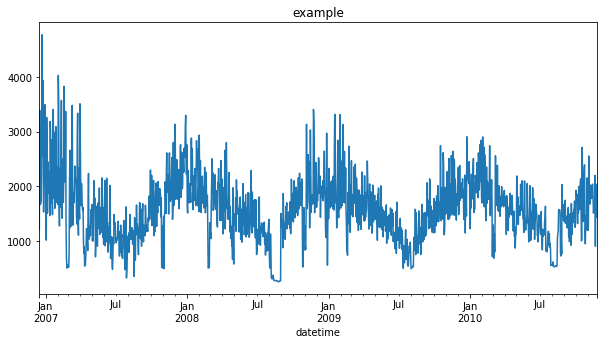

In [ ]:
daily_data['Global_active_power'].plot(figsize = (10, 5), title = 'example')

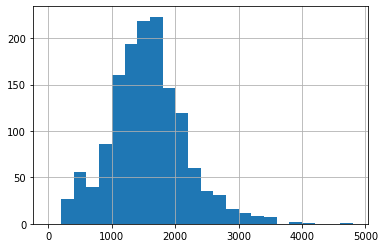

In [ ]:
daily_data['Global_active_power'].hist(bins = np.arange(0, 5000, 200))

## Transformation

Pandas also supports commonly used time series transformations and some methods from numpy library could also be interexchangely used with pandas. 

In [ ]:
daily_data = df.resample('D').sum()

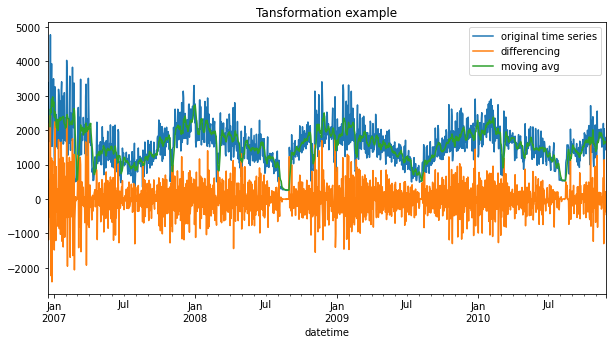

In [ ]:
daily_data['Global_active_power'].plot(title = 'Tansformation example', figsize = (10, 5), label = 'original time series')
daily_data['Global_active_power'].diff().plot(label = 'differencing')
daily_data['Global_active_power'].rolling(7).mean().dropna().plot(label = 'moving avg')
plt.legend()

In [ ]:
np.log(daily_data['Global_active_power']).head()

datetime
2006-12-16    7.097694
2006-12-17    8.128721
2006-12-18    7.697950
2006-12-19    7.418297
2006-12-20    7.707848
Freq: D, Name: Global_active_power, dtype: float64

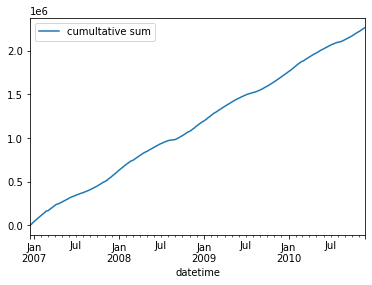

In [ ]:
daily_data['Global_active_power'].cumsum().plot(label = 'cumultative sum')
plt.legend()

# Modeling time series Part II : Time series forecasting

## Load dataset & clean data

This section aims to forecast the future value of `globalactivepower`on a weekly level.

In [ ]:
df = pd.read_csv('122_260_bundle_archive.zip', sep=';', 
                 parse_dates={'datetime' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'])
df = df.set_index('datetime')

In [ ]:
for j in range(0,len(df.columns)):        
    df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

In [ ]:
df = df['Global_active_power']
df.head()

datetime
2006-12-16 17:24:00    4.216
2006-12-16 17:25:00    5.360
2006-12-16 17:26:00    5.374
2006-12-16 17:27:00    5.388
2006-12-16 17:28:00    3.666
Name: Global_active_power, dtype: float64

## Aggregrate into a weekly data

In [ ]:
dataset = df.resample('W').sum()[1:-1] # ignore first and last datapoint as it might not contain the data from the whole week
print('time series length = ', len(dataset))
dataset.head()

time series length =  205


datetime
2006-12-24    17479.311230
2006-12-31    19738.701230
2007-01-07    14961.068000
2007-01-14    16177.425615
2007-01-21    16525.666000
Freq: W-SUN, Name: Global_active_power, dtype: float64

## Stationary Test

We could see that the dataset is clearly non-stationary as both mean and variance is not constant. Moreover, from the partial autocorrelation plot, there may be an element of seasonality on a yearly level. 

In [ ]:
rolmean = dataset.rolling(window=14).mean() 
rolstd = dataset.rolling(window=14).std()

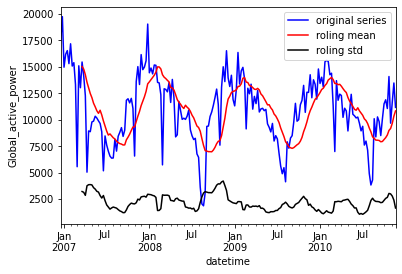

In [ ]:
plt.ylabel('Global_active_power')
dataset.plot( color = 'blue', label = 'original series')
rolmean.plot( color = 'red', label = 'roling mean')
rolstd.plot( color = 'black', label = 'roling std')
plt.legend()
plt.show()

In [ ]:
def plot_autocor(data, lags=None):
    plt.figure(figsize = (15, 4))
    plt.subplot(221) # w x h x id
    plt.title('series')
    plt.plot(data)
    plt.subplot(222)
    plt.title('histogram of the series')
    plt.hist(data)
    plt.show()
    sm.tsa.graphics.plot_acf(data, lags=lags, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, zero = False)
    plt.show()

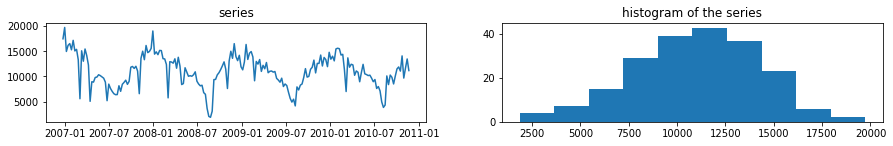

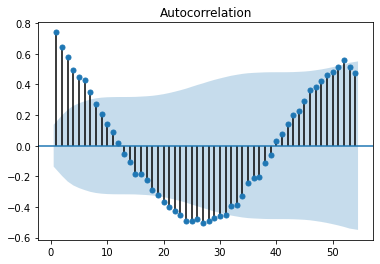

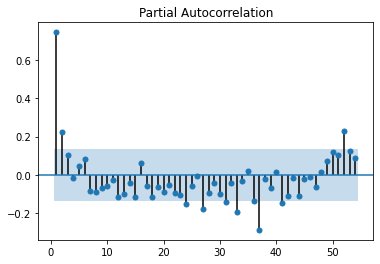

In [ ]:
plot_autocor(dataset, lags=54);

We also confirm this by using the Augmented Dickey-Fuller test (ADCF test), which is the method used to test whether the dataset is stationary. 

It was found that the p-value is lower than 0.05. Thus, we could reject the null hypothesis. Nevertheless, this could further improved with additional transformation.

In [ ]:
def get_ADCF_test(series):
    dftest = adfuller(series)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


In [ ]:
get_ADCF_test(dataset)

Test Statistic           -4.409511
p-value                   0.000286
Lags Used                 1.000000
Observations Used       203.000000
Critical Value (1%)      -3.462980
Critical Value (5%)      -2.875885
Critical Value (10%)     -2.574416
dtype: float64


## Build ARIMA model

Let's start by building a simple ARIMA model. But since our data has saesonality, we need to remove it first by differencing with the peroid (52). This can easily be done with the [diff](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.diff.html) function in pandas.

Note how the seasonal component seems to disappear.

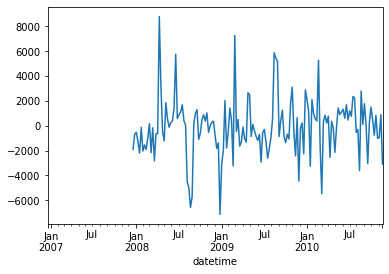

In [ ]:
dataset.diff(52).plot()

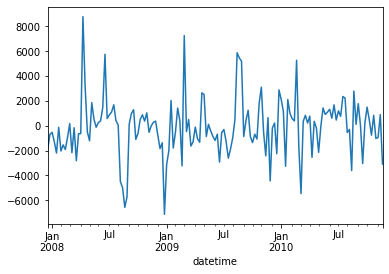

In [ ]:
diffdataset = dataset.diff(52)[52:]
diffdataset.plot()

Now let's try fitting a simple ARIMA model.

The goodness of fit for an ARIMA model are usually measure by the log-likelihood on the training data (the probability of seeing the training data given the fitted model).

In [ ]:
# Let's try creating an ARIMA model
p, d, q = 1, 1, 0
order = (p,d,q)

In [ ]:
arima_model = sm.tsa.ARIMA(diffdataset,
                                order=order).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               ARIMA Model Results                               
=================================================================================
Dep. Variable:     D.Global_active_power   No. Observations:                  152
Model:                    ARIMA(1, 1, 0)   Log Likelihood               -1407.641
Method:                          css-mle   S.D. of innovations           2543.666
Date:                   Sun, 01 Aug 2021   AIC                           2821.282
Time:                           18:21:13   BIC                           2830.353
Sample:                       12-30-2007   HQIC                          2824.967
                            - 11-21-2010                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -2.7299    150.462     -0.018      0.986    -297.630     292.171
ar.L1.D.Global_active_power    -0.3737      0.075     -4.951      0.000      -0.522      -0.226
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.6759           +0.0000j            2.6759            0.5000
-----------------------------------------------------------------------------
"""

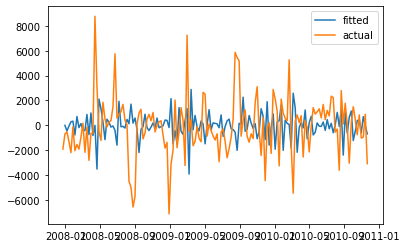

In [ ]:
plt.plot(arima_model.fittedvalues,label = 'fitted')
plt.plot(diffdataset,label = 'actual')
plt.legend()
plt.show()

A bigger model (higher order of p and q) usually generates better log likelihood (less negative value). Sometimes people use AIC or BIC scores which automatically compensates for model complexity in the scoring. The smaller the AIC or BIC values the better.

For those who are interested, more details on log likelihood, AIC, and BIC can be found [here](https://otexts.com/fpp2/arima-estimation.html)

We will talk more about selecting the order of the model when we do our SARIMA example next.

In [ ]:
# Let's try creating an ARIMA model
p, d, q = 4, 1, 1
order = (p,d,q)

In [ ]:
arima_model = sm.tsa.ARIMA(diffdataset,
                                order=order).fit()
arima_model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               ARIMA Model Results                               
=================================================================================
Dep. Variable:     D.Global_active_power   No. Observations:                  152
Model:                    ARIMA(4, 1, 1)   Log Likelihood               -1387.428
Method:                          css-mle   S.D. of innovations           2195.497
Date:                   Sun, 01 Aug 2021   AIC                           2788.855
Time:                           18:21:16   BIC                           2810.022
Sample:                       12-30-2007   HQIC                          2797.454
                            - 11-21-2010                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           4.7968      5.531      0.867      0.387      -6.044      15.637
ar.L1.D.Global_active_power     0.2756      0.082      3.364      0.001       0.115       0.436
ar.L2.D.Global_active_power     0.0383      0.085      0.453      0.651      -0.127       0.204
ar.L3.D.Global_active_power    -0.0340      0.084     -0.403      0.687      -0.199       0.131
ar.L4.D.Global_active_power    -0.0020      0.081     -0.024      0.981      -0.161       0.157
ma.L1.D.Global_active_power    -1.0000      0.018    -56.567      0.000      -1.035      -0.965
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.1993           -1.6091j            2.7251           -0.1005
AR.2            2.1993           +1.6091j            2.7251            0.1005
AR.3           -3.8377           -0.0000j            3.8377           -0.5000
AR.4          -17.8147           -0.0000j           17.8147           -0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

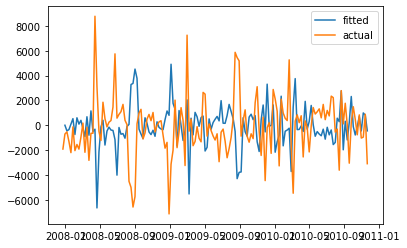

In [ ]:
plt.plot(arima_model.fittedvalues,label = 'fitted')
plt.plot(diffdataset,label = 'actual')
plt.legend()
plt.show()

## Build SARIMA model

In this part, we will try to fit the data using SARIMA which compose of seven hyperparameters: p, d, q, P, D, Q, m

- The p,d,q is a standard ARIMA term where:
    - p is the order of the autoregressive model
    - d is the order of difference
    - q is the order of the moving average model
  
- The additional P, D, Q, m is an additional SARIMA term where:
    - P is the order of the autoregressive model of the seasonal lag
    - D is the order of difference of the seasonal lag
    - Q is the order of the moving average model of the seasonal lag
    - m is the size of the period within one season

The parameters below were arbitrary chosen as an example.

In [ ]:
p, d, q = 1, 1, 0
P, D, Q, m  = 1, 1, 0, 52
order = (p,d,q)
seasonal_order = (P, D, Q, m)

In [ ]:
sarima_model = sm.tsa.statespace.SARIMAX(dataset,
                                order=order, 
                                seasonal_order=seasonal_order).fit()
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                Global_active_power   No. Observations:                  205
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 52)   Log Likelihood               -1395.361
Date:                            Sun, 01 Aug 2021   AIC                           2796.722
Time:                                    18:31:46   BIC                           2805.793
Sample:                                12-24-2006   HQIC                          2800.407
                                     - 11-21-2010                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3569      0.058     -6.125      0.000      -0.471      -0.243
ar.S.L52      -0.3678      0.049     -7.576      0.000      -0.463      -0.273
sigma2      5.411e+06   4.13e+05     13.115      0.000     4.6e+06    6.22e+06
===================================================================================
Ljung-Box (Q):                       32.43   Jarque-Bera (JB):                47.16
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                             0.36
Prob(H) (two-sided):                  0.67   Kurtosis:                         5.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Fit result

The figure below showed that the trained model could fit the data.

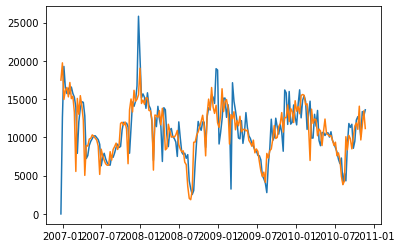

In [ ]:
plt.plot(sarima_model.fittedvalues)
plt.plot(dataset )

 The histogram of the residual seemed to be normal and the residual plot looked like random noise. However, the presence of significant lag in ACF and PACF plot show us that the model still might not be properly fitted.

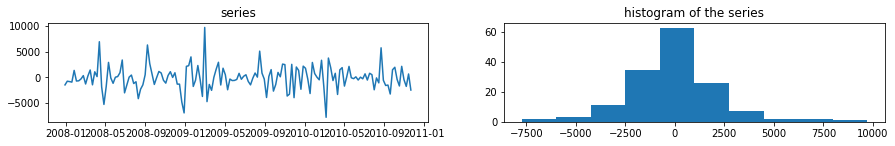

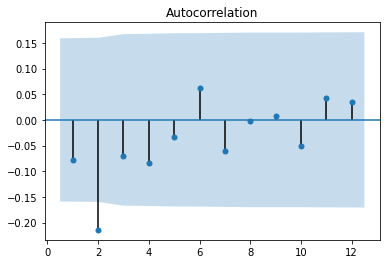

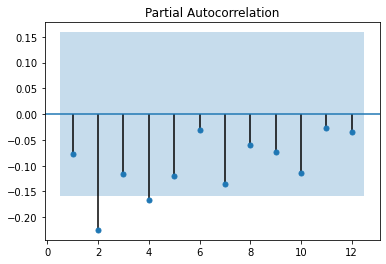

In [ ]:
plot_autocor(sarima_model.resid[sarima_model.loglikelihood_burn:], lags=12);

## Future prediction

We then try to briefly observe the model sensibleness by forecasting data for the next 100 steps. It was found that the model could follow trends and seasonality.

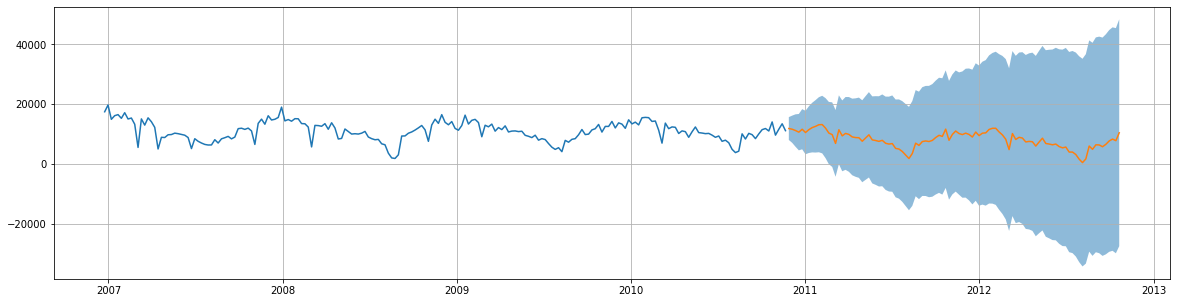

In [ ]:
future_fcst = sarima_model.get_forecast(100)
# We're selecting 90% confidence interval (alpha = 0.1)
confidence_int = future_fcst.conf_int(alpha = 0.1)
fcst = future_fcst.predicted_mean

plt.figure(figsize = (20, 5))
plt.plot(dataset )
plt.plot(fcst)
plt.fill_between(confidence_int.index,confidence_int['lower Global_active_power'],confidence_int['upper Global_active_power'],alpha = 0.5)
plt.grid()

## Parameter tuning setup

The section above showed us that the chosen parameters might not be optimal. Thus, we conducted a parameter tuning process to obtain a more accurate prediction. The example below showed an example of the parameter tuning process. It was done by searching for the best parameters in the validation set and then evaluated the searched model on the held-out test set.

First, we have to define the evaluation metric is measure the performance of the model. In this task, we compare the prediction result of 52 future timesteps (one year ahead) using MAPE as a primary metric.



In [ ]:
from tqdm import tqdm_notebook
def validate(series,horizon,start,step_size,order = (1,0,0),seasonal_order = (0,0,0,0)):
    y_pred = []
    y_true = []
    for i in tqdm_notebook(range(start,len(series)-horizon,step_size)):
        model = sm.tsa.statespace.SARIMAX(series[:i+1], order=order,  seasonal_order=seasonal_order).fit()
        y_pred.append(model.forecast(steps = horizon)[-1]) 
        y_true.append(series[i+horizon]) 
    return np.array(y_pred), np.array(y_true)

def mape(result):
  y_true, y_pred = result
  return abs((y_true - y_pred) / y_true).sum() / len(y_true)

We then split the series into a trainval set and test set.

In [ ]:
train_series = dataset[: 175]
test_series = dataset[175:]

Example of performance evaluation of the chosen parameters on the trainval set.

In [ ]:
order = (1,1,0)
seasonal_order = (1,1,0,52)
horizon = 52
start = 104 + 1
step_size = 4
result = validate(train_series, horizon, start, step_size, order = order, seasonal_order = seasonal_order)
print("validation MAPE = ", mape(result))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'



validation MAPE =  0.5027910991344775


Next, we seek the best model parameter by performing a grid search on each parameter. For simplicity, we only search `p` and `q` , and the seasonal order is still left unsearched. The result below showed us that the best `(p, d, q)` value is `(2, 1, 1)`. This also showed us that having a large value of `p` and `q` might not actually improve the model performance as it starts to overfit.

In [ ]:
def gridsearch(series, horizon, start, step_size, validation_fuction, p_range = [], d_range = [], q_range = [], m_range = []):
  #initialization
    best_mape = np.inf
    best_order = None
    best_seasonal_order = None
    # loop p, q, d, m for best parameter
    for p in p_range:
      for q in q_range:
        for d in d_range:
          for m in m_range:
            order = (p,d,q)
            sesonal_order = (1, 1, 0, m)
            error = mape(validation_fuction(series, horizon, start, step_size, order = order, seasonal_order = sesonal_order)) # evaluate the performance of the parameters
            print('(p, d, q) =', order, '(P, D, Q, m) =', sesonal_order, 'MAPE =', error)
            if(error < best_mape): #chose the current model as the best model if it perform better than the past search
              best_mape = error
              best_order = order
              best_seasonal_order = sesonal_order
    return best_mape, best_order, best_seasonal_order

In [ ]:
horizon = 52
start = 104 + 1
step_size = 4

best_mape, best_order, best_seasonal_order = gridsearch(train_series, horizon, start, step_size, validation_fuction = validate, p_range = [1, 2, 3, 4], d_range = [1], q_range = [0, 1], m_range = [52])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'



(p, d, q) = (1, 1, 0) (P, D, Q, m) = (1, 1, 0, 52) MAPE = 0.5027910991344775



(p, d, q) = (1, 1, 1) (P, D, Q, m) = (1, 1, 0, 52) MAPE = 0.17872708297978904



(p, d, q) = (2, 1, 0) (P, D, Q, m) = (1, 1, 0, 52) MAPE = 0.4873712058320945


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



(p, d, q) = (2, 1, 1) (P, D, Q, m) = (1, 1, 0, 52) MAPE = 0.17608949227276177



(p, d, q) = (3, 1, 0) (P, D, Q, m) = (1, 1, 0, 52) MAPE = 0.38714025830152116



(p, d, q) = (3, 1, 1) (P, D, Q, m) = (1, 1, 0, 52) MAPE = 0.40525060975340893



(p, d, q) = (4, 1, 0) (P, D, Q, m) = (1, 1, 0, 52) MAPE = 0.42375077106475734


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



(p, d, q) = (4, 1, 1) (P, D, Q, m) = (1, 1, 0, 52) MAPE = 0.40627050333169173


In [ ]:
print("Best params : (p,d,q) (P, D, Q, m) :", best_order, best_seasonal_order)

Best params : (p,d,q) (P, D, Q, m) : (2, 1, 1) (1, 1, 0, 52)


### Test set evaluation

The chosen parameters from the evaluation set were then used to train the model on the trainval set and evaluated on the test set. 


Fitting the model on the whole training series.

In [ ]:
sarima_model = sm.tsa.statespace.SARIMAX(train_series, order=best_order, seasonal_order=best_seasonal_order).fit()
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                Global_active_power   No. Observations:                  175
Model:             SARIMAX(2, 1, 1)x(1, 1, 0, 52)   Log Likelihood               -1118.553
Date:                            Sun, 01 Aug 2021   AIC                           2247.105
Time:                                    18:41:36   BIC                           2261.125
Sample:                                12-24-2006   HQIC                          2252.800
                                     - 04-25-2010                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3964      0.078      5.102      0.000       0.244       0.549
ar.L2          0.1225      0.075      1.631      0.103      -0.025       0.270
ma.L1         -0.9868      0.068    -14.410      0.000      -1.121      -0.853
ar.S.L52      -0.3506      0.065     -5.390      0.000      -0.478      -0.223
sigma2      4.737e+06   4.95e+05      9.577      0.000    3.77e+06    5.71e+06
===================================================================================
Ljung-Box (Q):                       22.40   Jarque-Bera (JB):                28.43
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                             0.35
Prob(H) (two-sided):                  0.74   Kurtosis:                         5.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

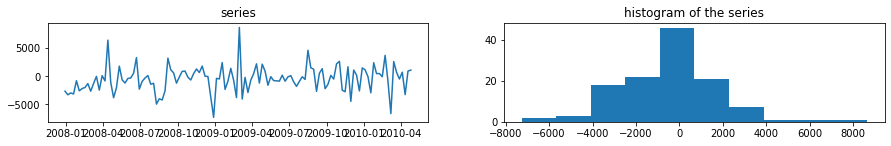

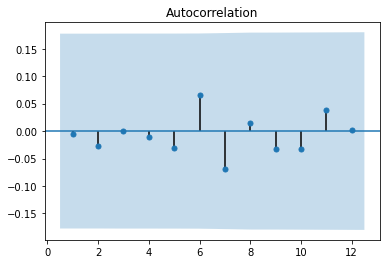

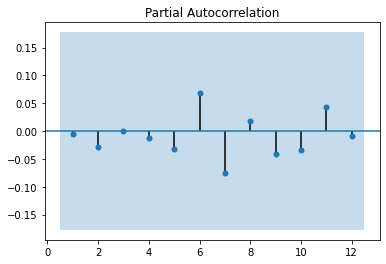

In [ ]:
plot_autocor(sarima_model.resid[sarima_model.loglikelihood_burn:], lags=12);

Evaluating model on the test set by forecasting every datapoints in the test time. The predicted value was evaluated by comparing it with the actual value using MAPE as a matric. The result showed us that the average test error is around 12%.

In [ ]:
y_pred = sarima_model.get_forecast(len(test_series))
test_error = mape((test_series.values, y_pred.predicted_mean))
print("TEST MAPE = ", test_error, ", nb. of test datapoints = ", len(test_series))

TEST MAPE =  0.12035368955598698 , nb. of test datapoints =  30


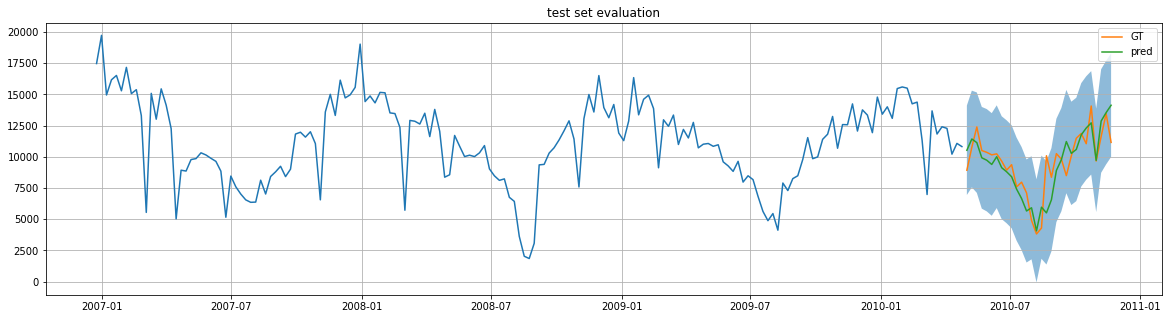

In [ ]:
confidence_int = y_pred.conf_int(alpha = 0.1)

plt.figure(figsize = (20, 5))
plt.title('test set evaluation')
plt.plot(train_series)
plt.plot(test_series, label = 'GT')
plt.plot(y_pred.predicted_mean, label = 'pred')
plt.fill_between(confidence_int.index,confidence_int['lower Global_active_power'],confidence_int['upper Global_active_power'],alpha = 0.5)
plt.legend()
plt.grid()

#### Future forcast

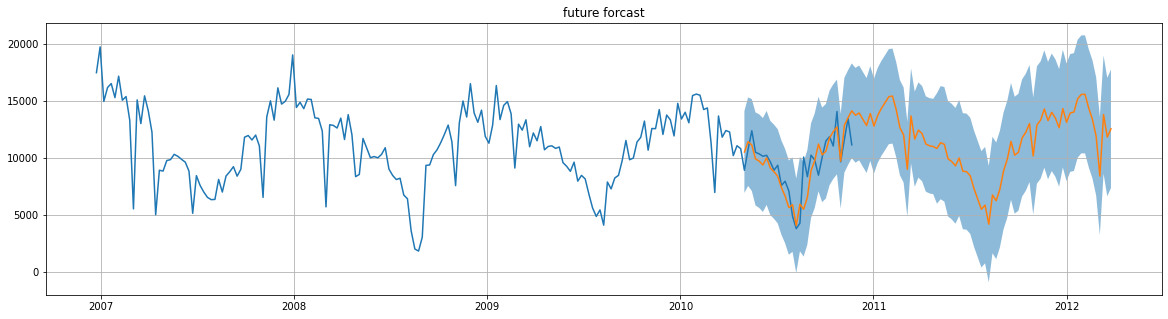

In [ ]:
future_fcst = sarima_model.get_forecast(100)
confidence_int = future_fcst.conf_int(alpha = 0.1)
fcst = future_fcst.predicted_mean

plt.figure(figsize = (20, 5))
plt.title('future forcast')
plt.plot(dataset )
plt.plot(fcst, label = 'future forcast')
plt.fill_between(confidence_int.index,confidence_int['lower Global_active_power'],confidence_int['upper Global_active_power'],alpha = 0.5)
plt.grid()
plt.show()